In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats
from functools import reduce
import statsmodels
import seaborn as sns
import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, savefig, despine

from spike_statistics.core import permutation_resampling_test, block_bootstrap

10:50:54 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-allcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation,field_area,theta_score
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.466836,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,69.775141,0.412306,-0.430279
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,62.102729,0.432396,0.307692
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.571614,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,61.189206,0.468221,-0.059705
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.428802,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,4.969741,0.425901,0.132632
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.083406,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000,0.395395,0.218721


In [5]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [6]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,orientation,field_area,theta_score,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,69.775141,0.412306,-0.430279,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,62.102729,0.432396,0.307692,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,61.189206,0.468221,-0.059705,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,4.969741,0.425901,0.132632,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.000000,0.395395,0.218721,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


# Statistics about all cell-sessions

In [7]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

In [8]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

# celltypes

In [9]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

data = data.merge(stim_results, how='left')

waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

data = data.merge(waveform_results, how='left')

data.bs = data.bs.astype(bool)

data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [10]:
data.loc[data.bs, 'cell_type'] = 'BS'
data.loc[data.ns_inhibited, 'cell_type'] = 'NSi'
data.loc[data.ns_not_inhibited, 'cell_type'] = 'NSn'

# Calculate statistics

In [11]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11 and stim_location=="ms"', 'baseline and ii and Hz30', 'frequency==30 and stim_location=="ms"']

In [12]:
columns = [
    'average_rate', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score'
]

In [13]:
results = {}
for cell_type, df in data.groupby('cell_type'):
    results[cell_type] = {}
    for key in columns:
        results[cell_type][key] = list()
        for query, label in zip(queries, labels):
            values = df.query(query).loc[:,['entity', 'unit_idnum', 'date', key]]
            results[cell_type][key].append(values.rename({key: label}, axis=1))

In [14]:
for cell_type, cell_type_val in results.items():
    for key, val in cell_type_val.items():
        df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
        results[cell_type][key] = df#.drop('unit_day',axis=1)

In [15]:
def drop_duplicates_least_null(df, key):
    return df.loc[df.notnull().sum(1).groupby(df[key]).idxmax()]

In [16]:
for cell_type, val in results.items():
    for key, df in val.items():
        results[cell_type][key] = drop_duplicates_least_null(df, 'unit_idnum')

In [17]:
bootstrap_results = {}
for cell_type in results:
    bootstrap_results[cell_type] = {}
    for key, df in results[cell_type].items():
        bootstrap_results[cell_type][key] = pd.DataFrame()
        group = df.groupby('entity')
        for label in labels:
            entity_values = np.array([d.loc[:, label].dropna().values for _, d in group if d.loc[:, label].count() > 0])
            if len([i for j in entity_values for i in j]) < 3: # less than total 3 samples
                boot_samples = np.ones(100) * np.nan
            else:
                boot_samples = block_bootstrap(entity_values, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
            bootstrap_results[cell_type][key].loc[:, label] = np.ravel(boot_samples)

In [18]:
bootstrap_results['NSi']['speed_score']

,Baseline I,11 Hz,Baseline II,30 Hz
0,NaN,0.100615,NaN,0.250866
1,NaN,0.255170,NaN,0.327961
2,NaN,0.144845,NaN,0.251898
3,NaN,0.095269,NaN,0.218489
4,NaN,0.146450,NaN,0.305831
...,...,...,...,...
95,NaN,0.186746,NaN,0.191186
96,NaN,0.173619,NaN,0.252210
97,NaN,0.132446,NaN,0.194481
98,NaN,0.171826,NaN,0.212224


# Create nice table

In [51]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(average_control - case)
    
    case_shift = case - case.mean()
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e} [{:.2f}, {:.2f}]".format(pval, low, high)


def power(df, df_bootstrap, control_key, case_key, effect_size, significance_level):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    case_shift = case - case.mean() + average_control + effect_size
    diff = abs(average_case - average_control)    
    
    power = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e}".format(power)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [52]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        
        for label in labels:
            average, sem, n = compute_weighted_mean_sem(results[cell_type][key], label)
            if np.isnan(average):
                stat.loc[label, Key] = np.nan
            else:
                stat.loc[label, Key] = "{:.2f} ± {:.2f} ({})".format(average, sem, n)

        for i, c1 in enumerate(df.columns):
            for c2 in df.columns[i+1:]:
                stat.loc[f'{c1} - {c2}', Key] = pvalue(results[cell_type][key], df, c1, c2)

    stats[cell_type] = stat


In [53]:
stats['BS']

,Average rate,Sparsity,Selectivity,Information specificity,Max rate,Information rate,Interspike interval cv,Out-field mean rate,Burst event ratio,Specificity,Speed score
Baseline I,10.15 ± 0.48 (269),0.71 ± 0.01 (269),5.36 ± 0.27 (269),0.19 ± 0.01 (269),33.20 ± 1.11 (269),0.89 ± 0.04 (269),2.40 ± 0.09 (269),8.41 ± 0.44 (269),0.23 ± 0.01 (269),0.35 ± 0.01 (269),0.11 ± 0.01 (269)
11 Hz,11.07 ± 0.55 (281),0.76 ± 0.01 (281),5.24 ± 0.38 (281),0.15 ± 0.01 (281),31.32 ± 1.20 (281),0.65 ± 0.04 (281),1.90 ± 0.05 (281),9.51 ± 0.51 (281),0.21 ± 0.01 (281),0.31 ± 0.01 (281),0.09 ± 0.01 (281)
Baseline II,9.93 ± 0.59 (194),0.71 ± 0.02 (194),5.31 ± 0.32 (194),0.18 ± 0.02 (194),33.07 ± 1.50 (194),0.86 ± 0.06 (194),2.32 ± 0.13 (194),8.24 ± 0.55 (194),0.21 ± 0.01 (194),0.35 ± 0.02 (194),0.08 ± 0.01 (194)
30 Hz,11.67 ± 0.66 (188),0.77 ± 0.02 (188),4.87 ± 0.31 (188),0.15 ± 0.02 (188),35.57 ± 1.60 (188),0.71 ± 0.04 (188),1.92 ± 0.06 (188),10.11 ± 0.63 (188),0.19 ± 0.01 (188),0.30 ± 0.02 (188),0.11 ± 0.01 (188)
Baseline I - 11 Hz,"7.4e-01 [-5.16, 3.43]","3.6e-01 [-0.14, 0.06]","9.1e-01 [-2.12, 1.79]","3.8e-01 [-0.06, 0.12]","5.9e-01 [-6.67, 8.37]","5.0e-02 [-0.05, 0.45]","1.0e-02 [0.06, 0.81]","5.8e-01 [-5.45, 2.05]","5.1e-01 [-0.03, 0.05]","3.5e-01 [-0.06, 0.13]","4.9e-01 [-0.03, 0.06]"
Baseline I - Baseline II,"9.0e-01 [-3.10, 3.84]","9.7e-01 [-0.09, 0.10]","9.2e-01 [-1.60, 1.34]","8.8e-01 [-0.08, 0.08]","9.9e-01 [-6.53, 5.95]","7.8e-01 [-0.21, 0.29]","6.8e-01 [-0.55, 0.52]","9.3e-01 [-4.28, 3.76]","4.2e-01 [-0.03, 0.05]","9.7e-01 [-0.12, 0.11]","3.2e-01 [-0.02, 0.08]"
Baseline I - 30 Hz,"5.1e-01 [-6.58, 2.88]","2.5e-01 [-0.14, 0.03]","5.8e-01 [-1.21, 1.87]","4.3e-01 [-0.07, 0.10]","5.7e-01 [-12.55, 6.92]","7.0e-02 [-0.03, 0.37]","0.0e+00 [0.15, 0.72]","4.8e-01 [-6.23, 3.48]","6.0e-02 [-0.00, 0.08]","3.8e-01 [-0.08, 0.15]","9.4e-01 [-0.05, 0.05]"
11 Hz - Baseline II,"5.5e-01 [-2.19, 4.76]","3.0e-01 [-0.04, 0.14]","9.2e-01 [-1.73, 1.21]","5.3e-01 [-0.12, 0.04]","6.3e-01 [-8.41, 4.07]","1.1e-01 [-0.46, 0.05]","1.2e-01 [-1.05, 0.03]","5.8e-01 [-3.17, 4.86]","9.6e-01 [-0.04, 0.04]","4.2e-01 [-0.16, 0.07]","6.8e-01 [-0.04, 0.06]"
11 Hz - 30 Hz,"8.0e-01 [-5.67, 3.79]","9.2e-01 [-0.09, 0.08]","6.9e-01 [-1.33, 1.75]","9.6e-01 [-0.11, 0.06]","3.6e-01 [-14.43, 5.04]","5.8e-01 [-0.27, 0.12]","8.8e-01 [-0.35, 0.22]","8.2e-01 [-5.13, 4.58]","1.9e-01 [-0.02, 0.06]","9.6e-01 [-0.13, 0.11]","5.0e-01 [-0.06, 0.03]"
Baseline II - 30 Hz,"4.8e-01 [-6.81, 2.65]","2.5e-01 [-0.14, 0.03]","6.3e-01 [-1.26, 1.82]","5.8e-01 [-0.08, 0.09]","5.5e-01 [-12.68, 6.79]","1.7e-01 [-0.07, 0.33]","0.0e+00 [0.07, 0.64]","4.3e-01 [-6.40, 3.31]","2.1e-01 [-0.02, 0.06]","3.4e-01 [-0.08, 0.15]","2.2e-01 [-0.07, 0.02]"


In [54]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [46]:
def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')

#     return "{:.2f}, {:.2f}, {:.2f}, {:.1e}, ({})".format(dff[keys[0]].mean(), dff[keys[1]].mean(), statistic, pvalue, len(dff))
    return "{:.2f}, {:.1e}, ({})".format(statistic, pvalue, len(dff))


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    d1 = df[keys[0]].dropna()
    d2 = df[keys[1]].dropna()
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        d1, d2, alternative='two-sided')

#     return"{:.2f}, {:.2f}, {:.0f}, {:.1e}, ({}), ({})".format(d1.mean(), d2.mean(), Uvalue, pvalue, len(d1), len(d2))
#     return"{:.0f}, {:.1e}".format(Uvalue, pvalue)
    return pvalue

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.1e}".format(statistic, pvalue)


In [47]:
paired_stats = {}
for cell_type, cell_results in results.items():
    paired_stat = pd.DataFrame()

    for key, df in cell_results.items():
        Key = rename(key)

        for label in labels:
            norm = normality(df, label) if df[label].count() >= 8 else np.nan
            paired_stat.loc[f'Normality {label}', Key] = norm

        for i, c1 in enumerate(labels):
            for c2 in labels[i+1:]:
    #             paired_stat.loc[f'{c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
                paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
    #             paired_stat.loc[f'MWU {c1} - {c2}', Key] = MWU(df, [c1, c2])
    paired_stats[cell_type] = paired_stat

paired_stat

,Average rate,Sparsity,Selectivity,Information specificity,Max rate,Information rate,Interspike interval cv,Out-field mean rate,Burst event ratio,Specificity,Speed score
Normality Baseline I,"3.65, 1.6e-01","38.41, 4.6e-09","48.61, 2.8e-11","51.14, 7.9e-12","2.81, 2.4e-01","11.41, 3.3e-03","34.41, 3.4e-08","4.38, 1.1e-01","6.35, 4.2e-02","45.08, 1.6e-10","0.33, 8.5e-01"
Normality 11 Hz,"6.42, 4.0e-02","17.48, 1.6e-04","25.90, 2.4e-06","28.51, 6.5e-07","0.10, 9.5e-01","44.49, 2.2e-10","29.16, 4.7e-07","6.77, 3.4e-02","2.92, 2.3e-01","32.57, 8.5e-08","2.26, 3.2e-01"
Normality Baseline II,"3.11, 2.1e-01","27.41, 1.1e-06","20.61, 3.4e-05","71.00, 3.8e-16","1.03, 6.0e-01","15.45, 4.4e-04","16.60, 2.5e-04","3.45, 1.8e-01","1.40, 5.0e-01","34.64, 3.0e-08","5.44, 6.6e-02"
Normality 30 Hz,"2.38, 3.0e-01","26.69, 1.6e-06","27.44, 1.1e-06","43.50, 3.6e-10","2.36, 3.1e-01","3.75, 1.5e-01","26.66, 1.6e-06","1.52, 4.7e-01","2.21, 3.3e-01","30.50, 2.4e-07","2.20, 3.3e-01"
Wilcoxon Baseline I - 11 Hz,"50.00, 8.8e-01, (14)","8.00, 5.2e-03, (14)","29.00, 1.4e-01, (14)","8.00, 5.2e-03, (14)","31.00, 1.8e-01, (14)","6.00, 3.5e-03, (14)","20.00, 4.1e-02, (14)","48.00, 7.8e-01, (14)","28.00, 1.2e-01, (14)","31.00, 1.8e-01, (14)","27.00, 1.1e-01, (14)"
Wilcoxon Baseline I - Baseline II,"35.00, 1.6e-01, (15)","22.00, 3.1e-02, (15)","39.00, 2.3e-01, (15)","22.00, 3.1e-02, (15)","52.00, 6.5e-01, (15)","27.00, 6.1e-02, (15)","32.00, 1.1e-01, (15)","32.00, 1.1e-01, (15)","22.00, 3.1e-02, (15)","17.00, 1.5e-02, (15)","20.00, 2.3e-02, (15)"
Wilcoxon Baseline I - 30 Hz,"34.00, 1.4e-01, (15)","5.00, 1.8e-03, (15)","10.00, 4.5e-03, (15)","3.00, 1.2e-03, (15)","46.00, 4.3e-01, (15)","7.00, 2.6e-03, (15)","0.00, 6.5e-04, (15)","34.00, 1.4e-01, (15)","19.00, 2.0e-02, (15)","12.00, 6.4e-03, (15)","56.00, 8.2e-01, (15)"
Wilcoxon 11 Hz - Baseline II,"26.00, 1.7e-02, (17)","76.00, 9.8e-01, (17)","62.00, 4.9e-01, (17)","64.00, 5.5e-01, (17)","21.00, 8.6e-03, (17)","46.00, 1.5e-01, (17)","43.00, 1.1e-01, (17)","26.00, 1.7e-02, (17)","48.00, 1.8e-01, (17)","65.00, 5.9e-01, (17)","61.00, 4.6e-01, (17)"
Wilcoxon 11 Hz - 30 Hz,"29.00, 7.2e-01, (11)","15.00, 1.1e-01, (11)","23.00, 3.7e-01, (11)","18.00, 1.8e-01, (11)","32.00, 9.3e-01, (11)","21.00, 2.9e-01, (11)","0.00, 3.3e-03, (11)","27.00, 5.9e-01, (11)","6.00, 1.6e-02, (11)","15.00, 1.1e-01, (11)","28.00, 6.6e-01, (11)"
Wilcoxon Baseline II - 30 Hz,"102.00, 4.3e-01, (22)","86.00, 1.9e-01, (22)","110.00, 5.9e-01, (22)","87.00, 2.0e-01, (22)","103.00, 4.5e-01, (22)","115.00, 7.1e-01, (22)","57.00, 2.4e-02, (22)","101.00, 4.1e-01, (22)","39.00, 4.5e-03, (22)","99.00, 3.7e-01, (22)","89.00, 2.2e-01, (22)"


In [48]:
for cell_type, paired_stat in paired_stats.items():
    paired_stat.to_latex(output_path / "statistics" / f"paired-statistics_{cell_type}.tex")
    paired_stat.to_csv(output_path / "statistics" / f"paired-statistics_{cell_type}.csv")

In [26]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

## Cumulative density plots

In [27]:

plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (3.7, 2.2), 
    'figure.dpi': 150
})

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-pac

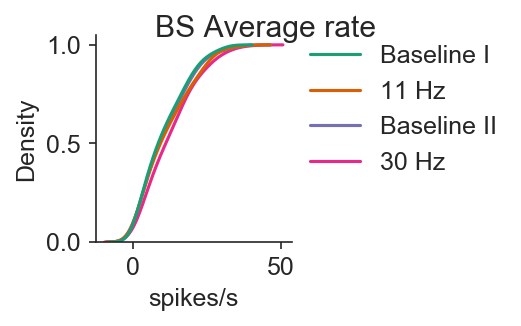

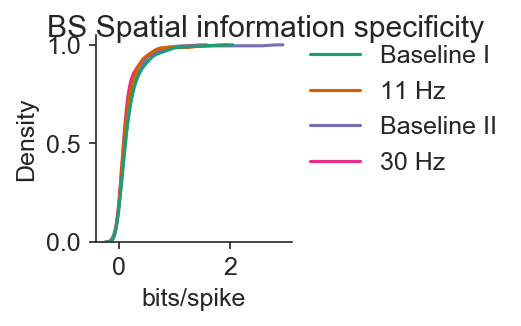

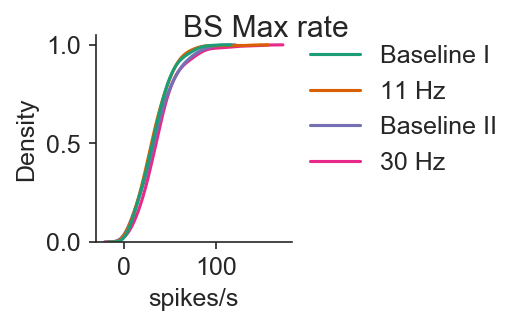

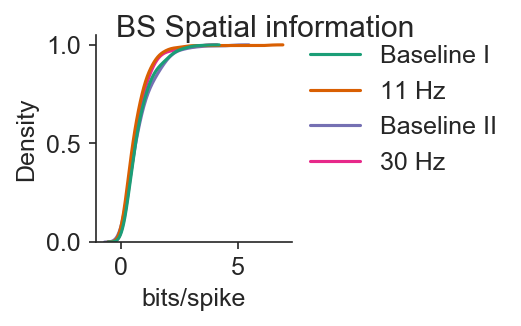

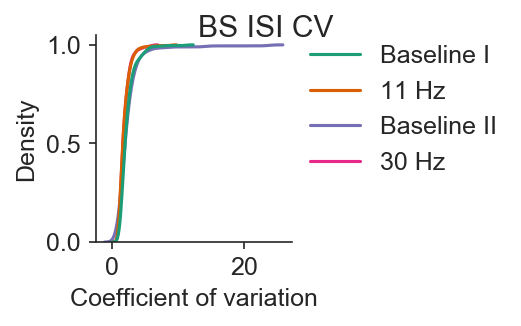

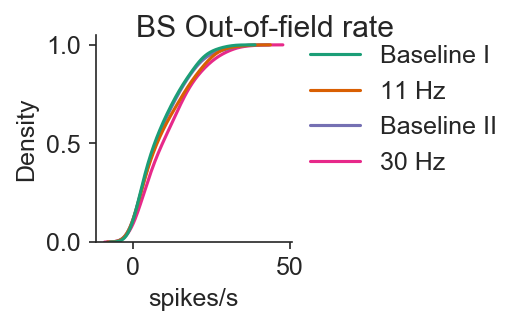

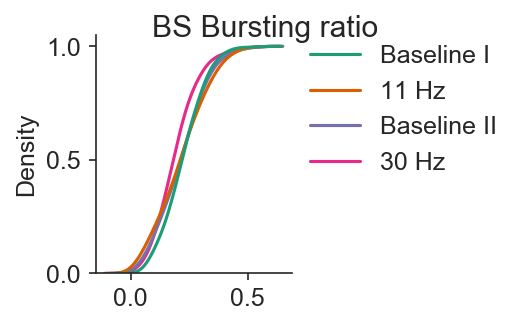

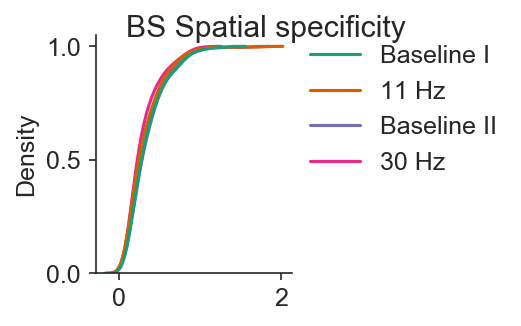

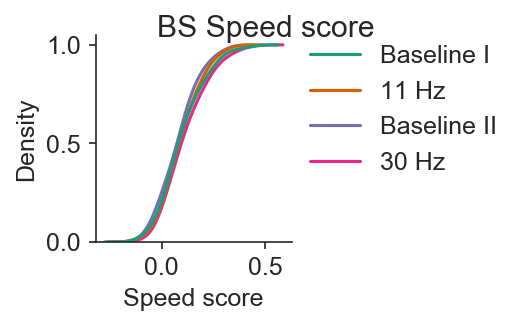

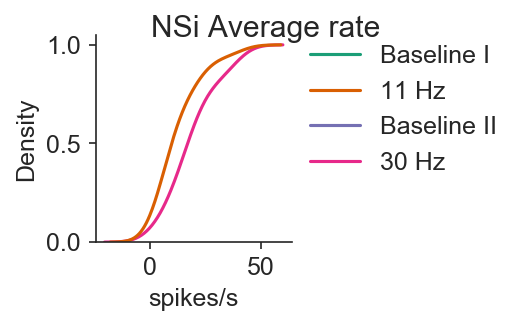

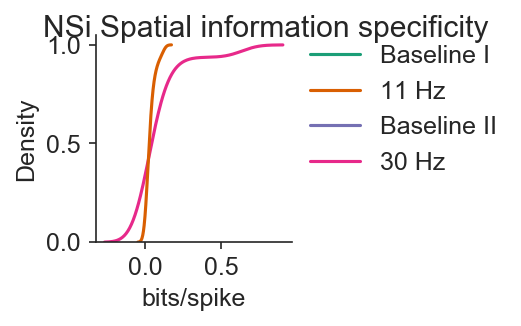

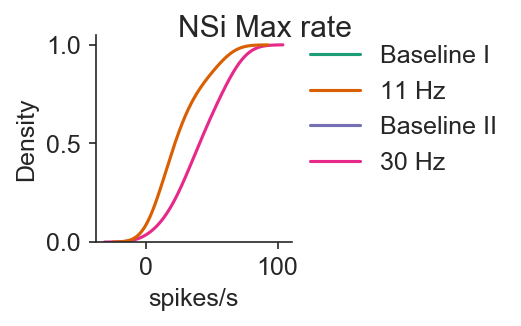

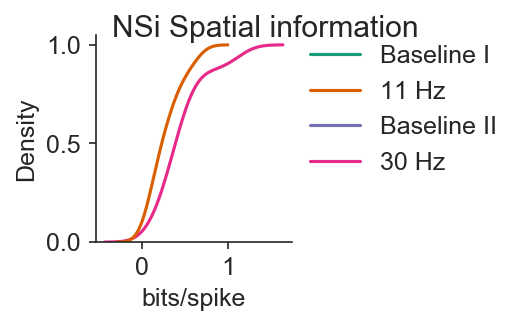

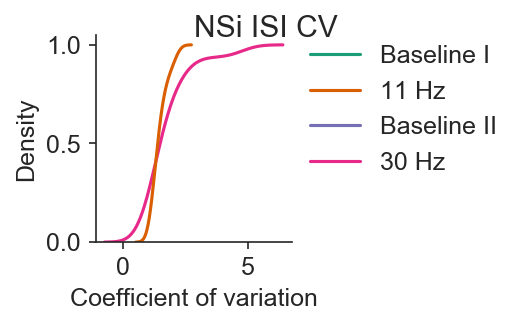

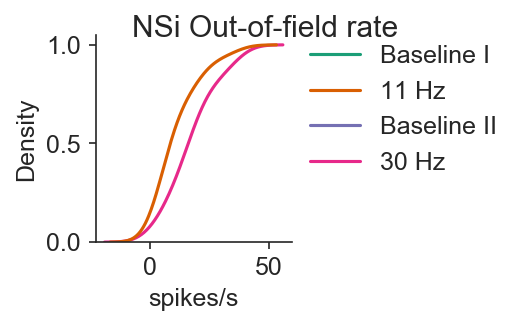

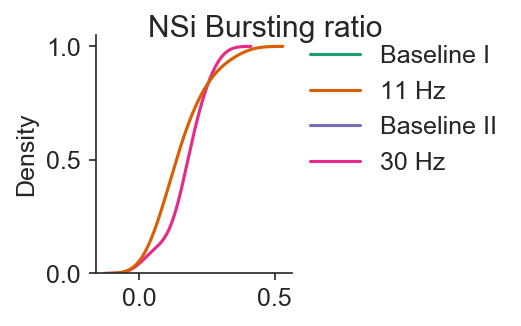

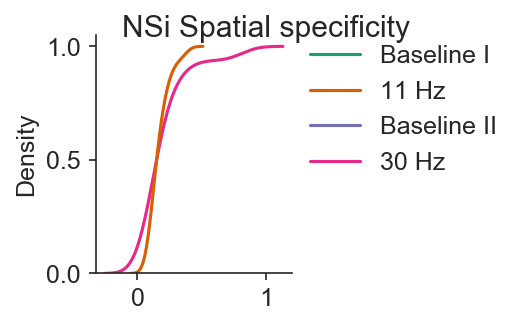

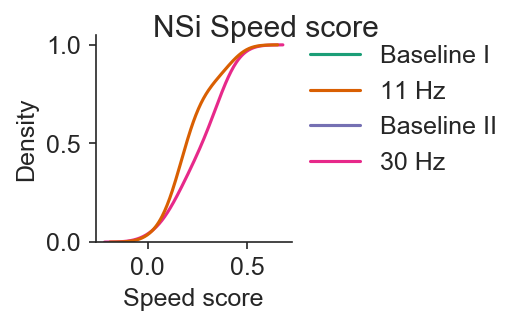

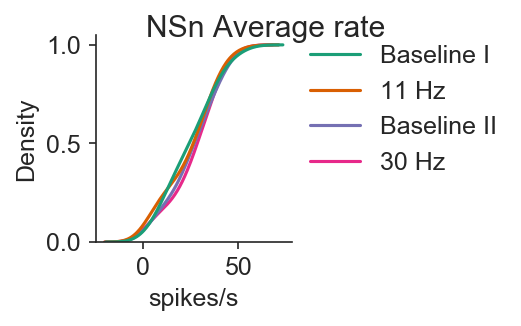

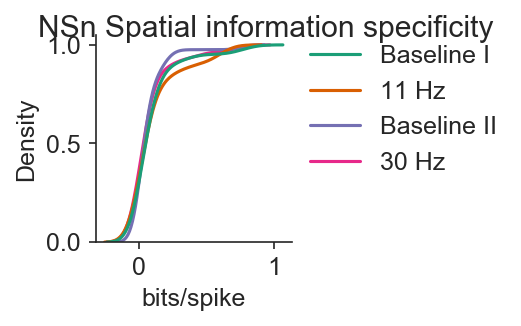

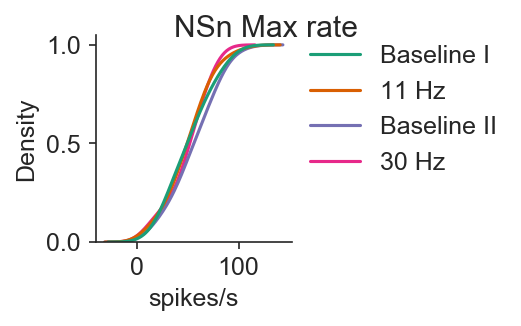

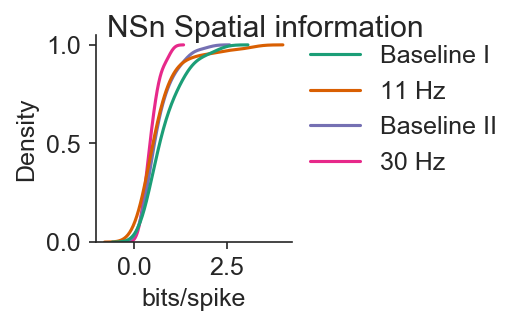

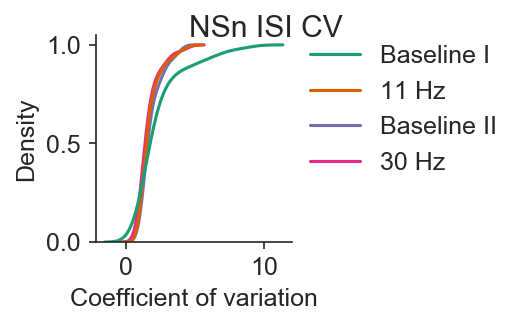

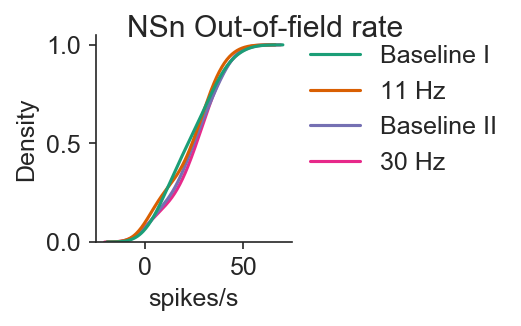

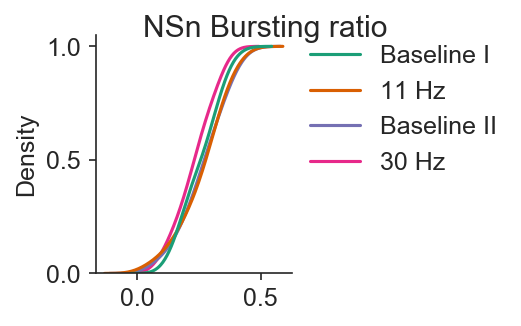

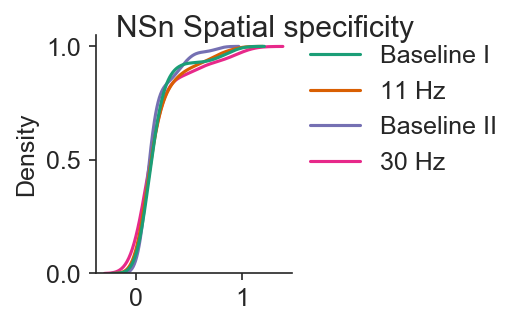

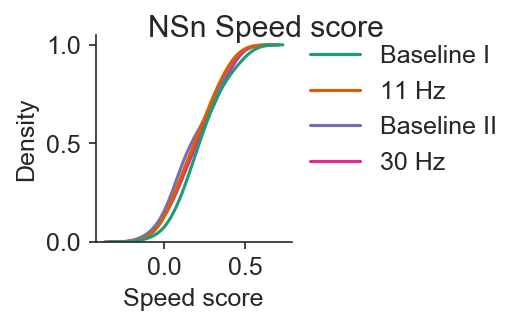

In [28]:
title_xlabel = {
    'information_rate': ('Spatial information','bits/spike'),
    'information_specificity': ("Spatial information specificity","bits/spike"),
    'specificity': ("Spatial specificity", ""),
    'average_rate': ("Average rate", "spikes/s"),
    'max_rate': ("Max rate", "spikes/s"),
    'interspike_interval_cv': ("ISI CV", "Coefficient of variation"),
    'in_field_mean_rate': ("In-field rate", "spikes/s"),
    'out_field_mean_rate': ("Out-of-field rate", "spikes/s"),
    'burst_event_ratio': ("Bursting ratio", ""),
    'gridness': ("Gridness", "Gridness"),
    'speed_score': ("Speed score", "Speed score"),

}

for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        if key not in title_xlabel:
            continue
        fig = plt.figure()
        plt.suptitle(cell_type + ' ' + title_xlabel[key][0])
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=result.loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(title_xlabel[key][1])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        savefig(output_path / "figures" / (cell_type + ' ' + key))

# Violinplot

In [29]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7*3, 3), 
    'figure.dpi': 150
})

# Information rate

In [30]:
def violinplot(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmedians=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


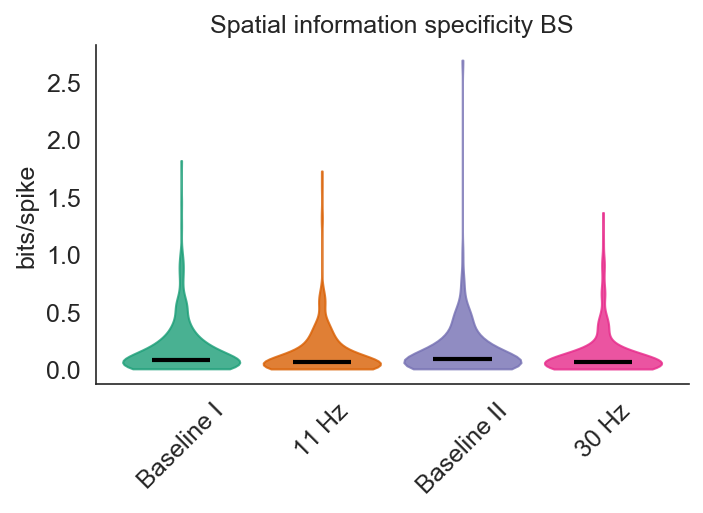

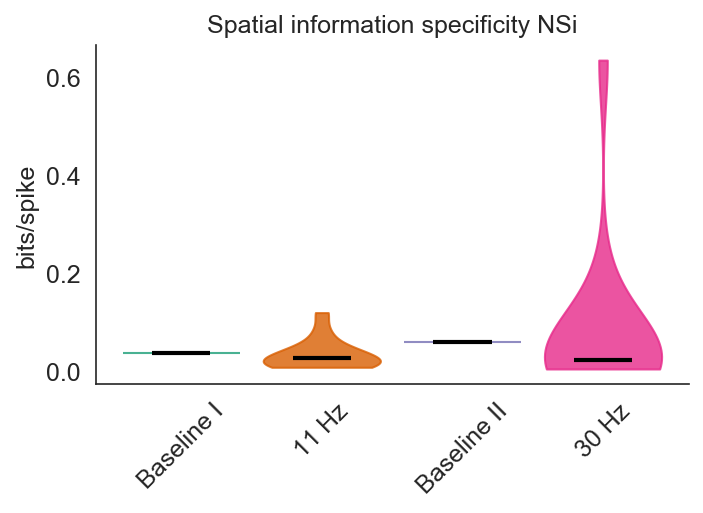

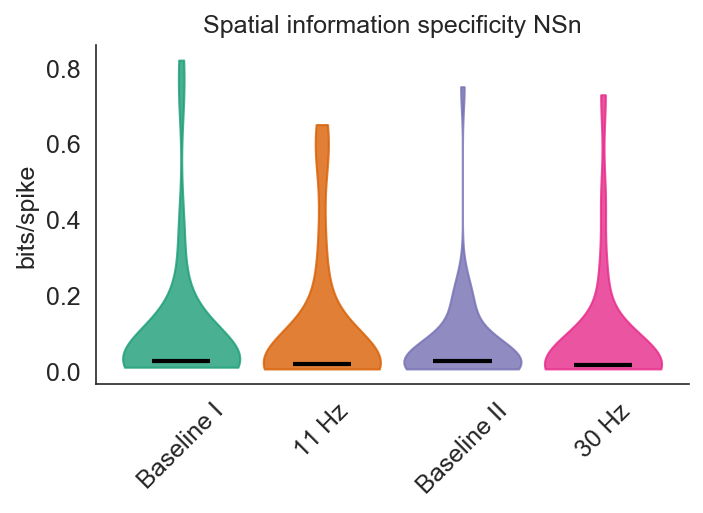

In [31]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['information_specificity'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Spatial information specificity {cell_type}")
    plt.ylabel("bits/spike")
    # plt.ylim(-0.2, 1.6)

    savefig(output_path / "figures" / f"information_specificity_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


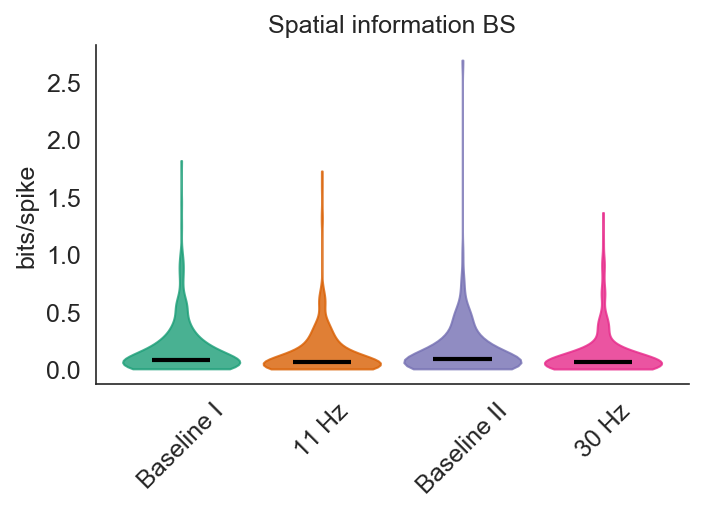

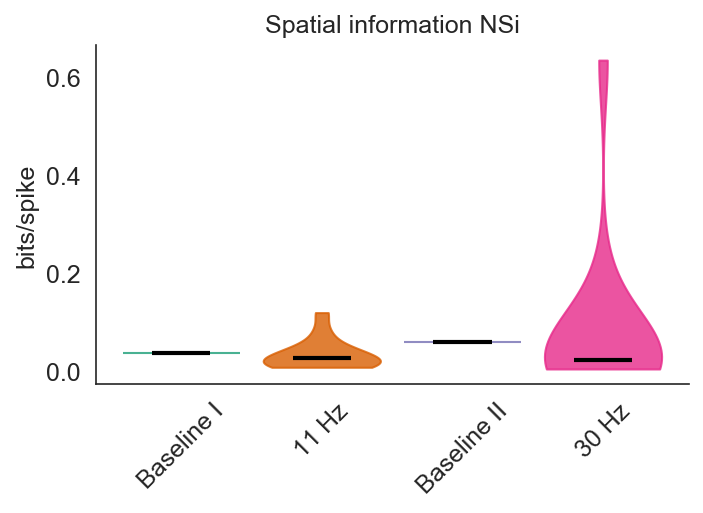

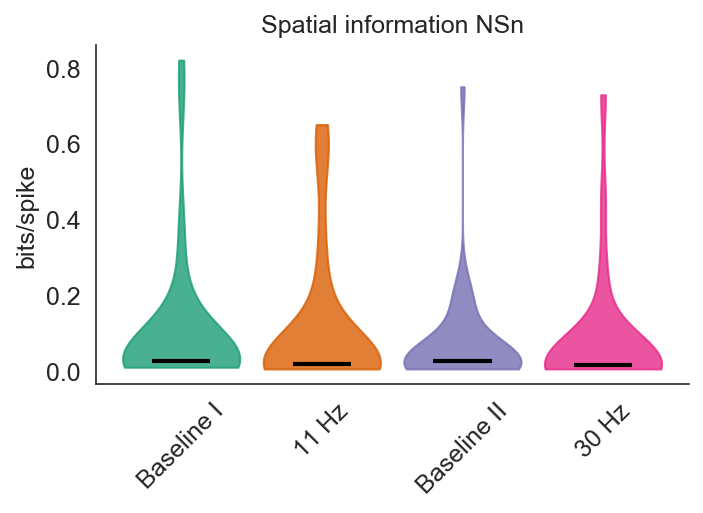

In [32]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['information_specificity'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Spatial information {cell_type}")
    plt.ylabel("bits/spike")
    # plt.ylim(-0.2, 1.6)

    savefig(output_path / "figures" / f"spatial_information_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


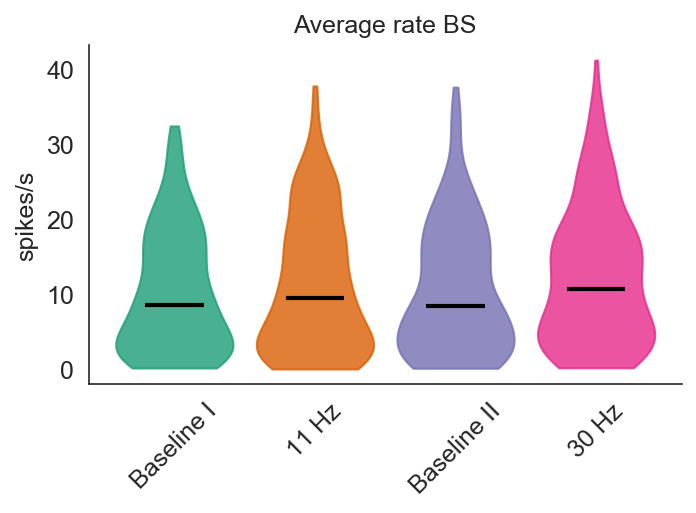

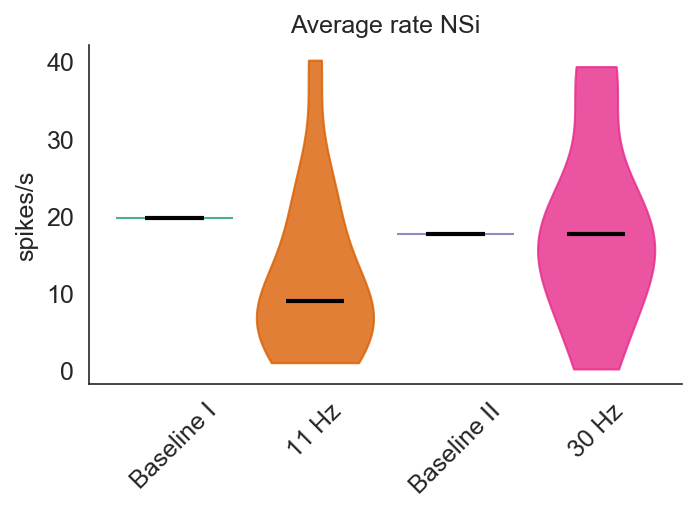

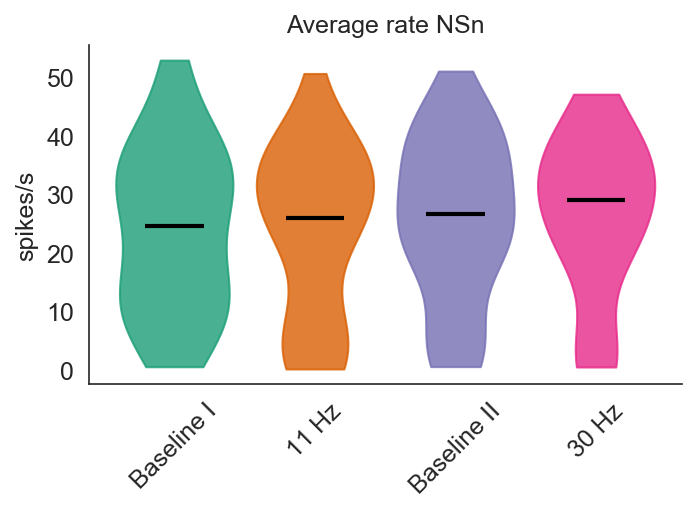

In [33]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['average_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Average rate {cell_type}")
    plt.ylabel("spikes/s")

    savefig(output_path / "figures" / f"average_rate_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


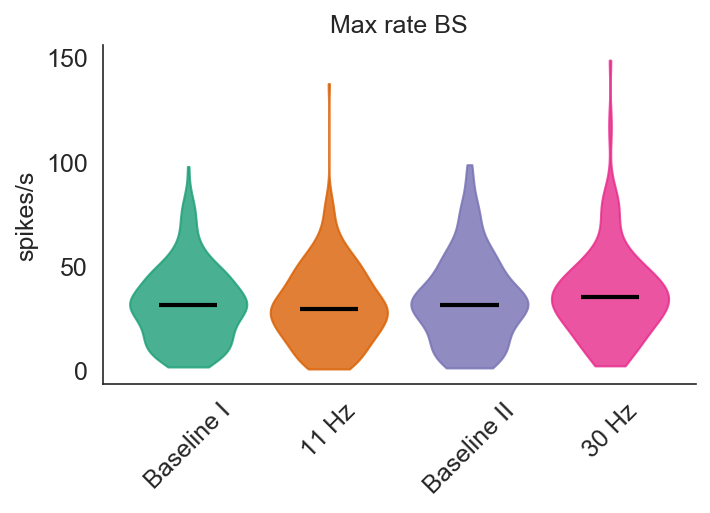

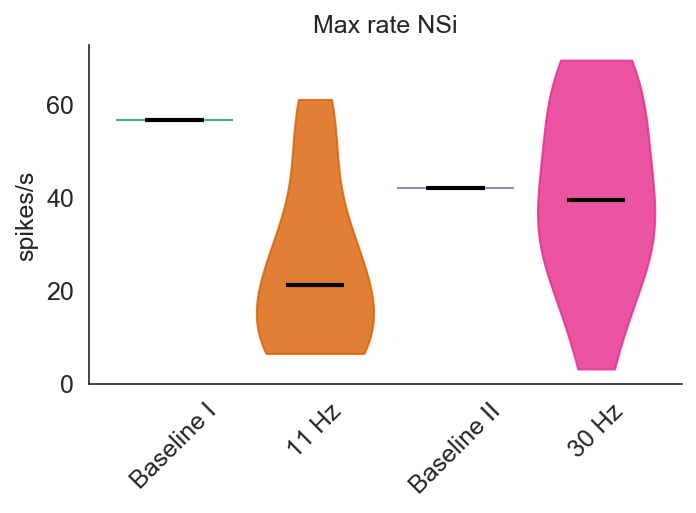

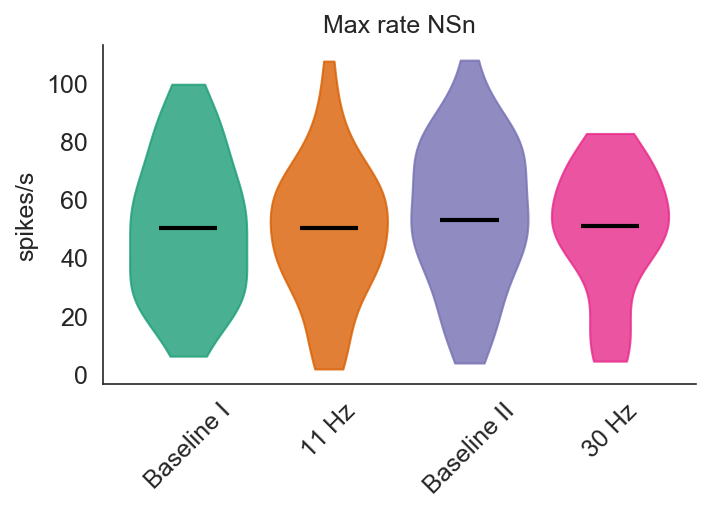

In [34]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['max_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Max rate {cell_type}")
    plt.ylabel("spikes/s")

    savefig(output_path / "figures" / f"max_rate_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


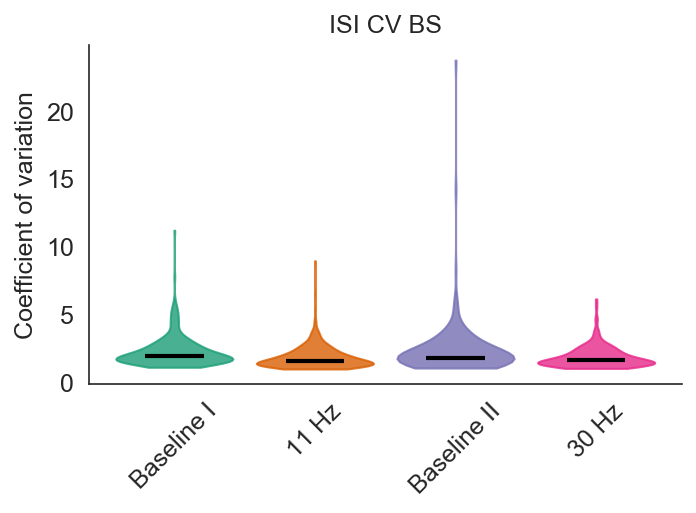

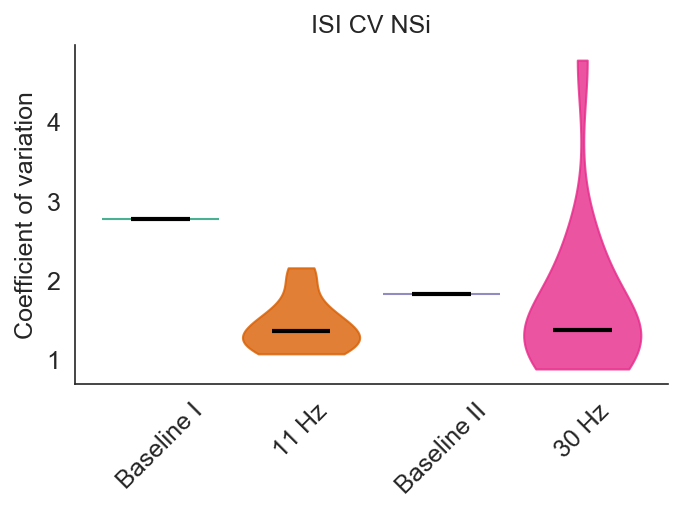

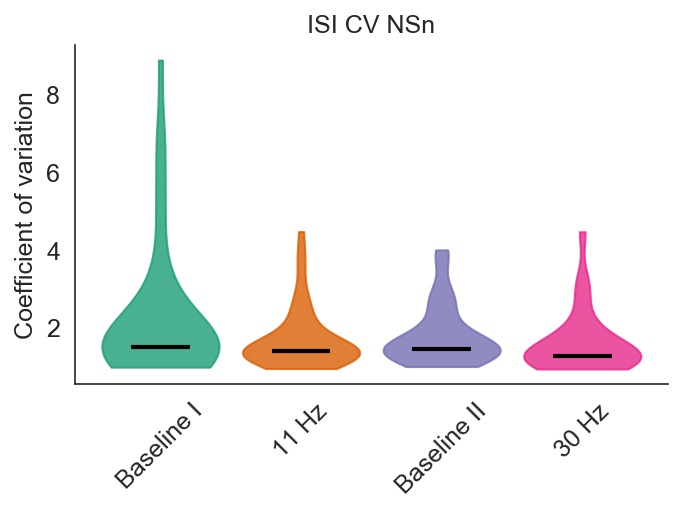

In [35]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['interspike_interval_cv'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"ISI CV {cell_type}")
    plt.ylabel("Coefficient of variation")

    savefig(output_path / "figures" / f"isi_cv_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


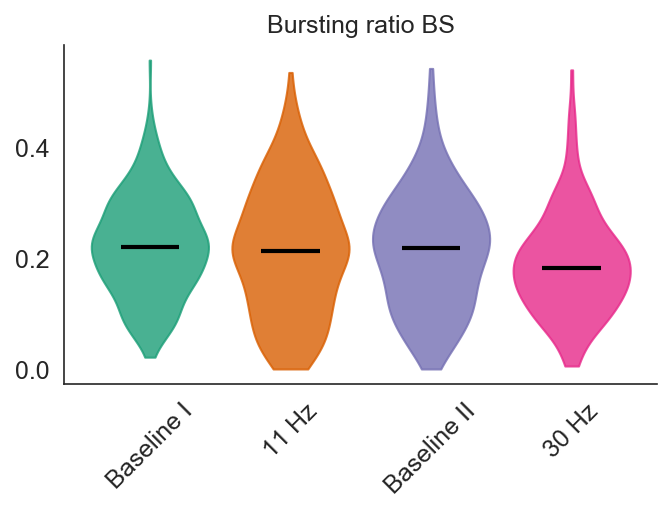

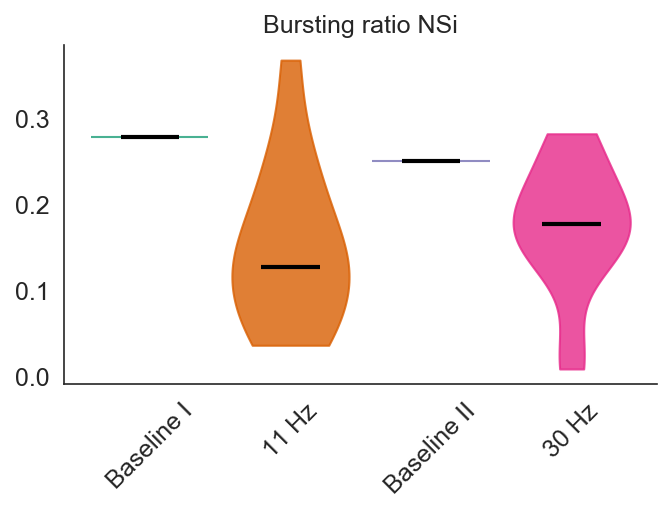

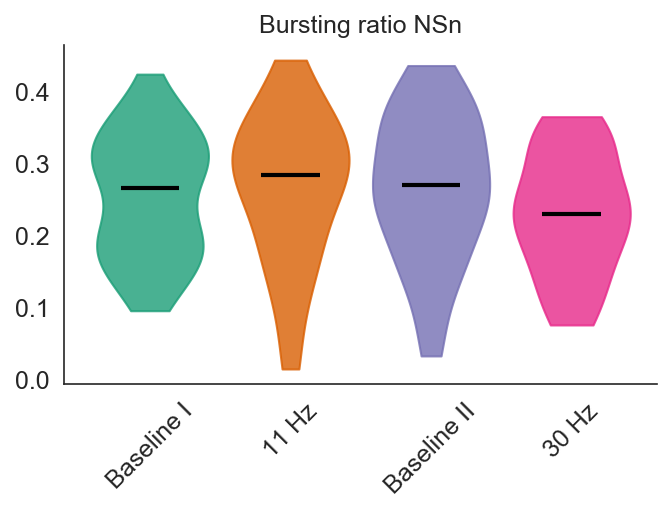

In [36]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['burst_event_ratio'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Bursting ratio {cell_type}")
    plt.ylabel("")

    savefig(output_path / "figures" / f"burst_event_ratio_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


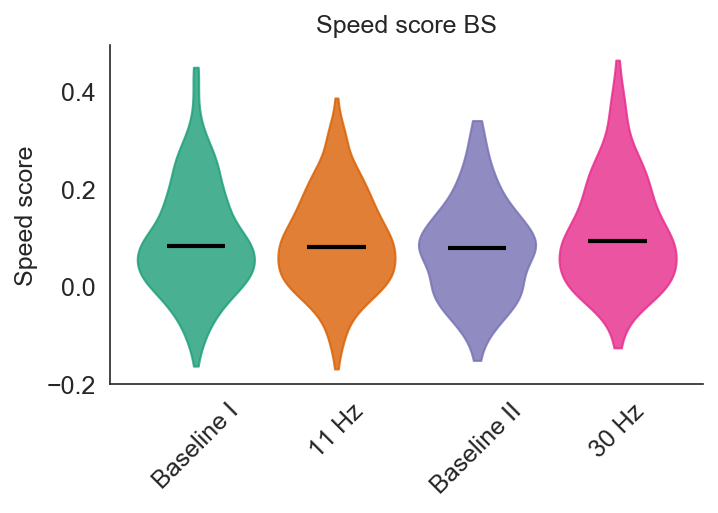

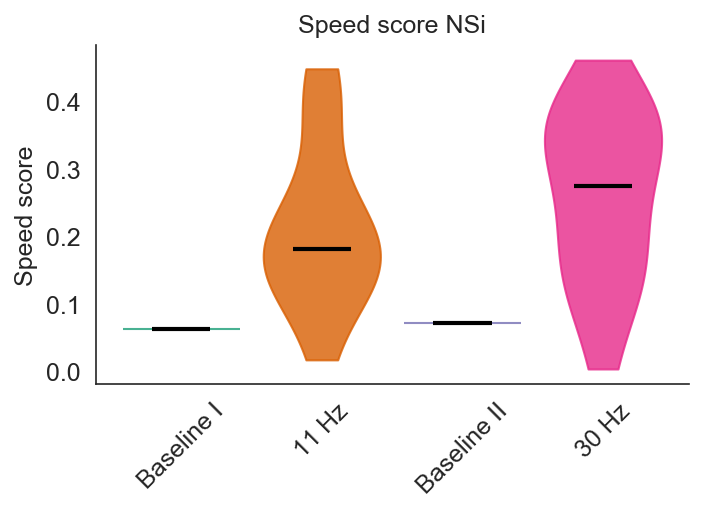

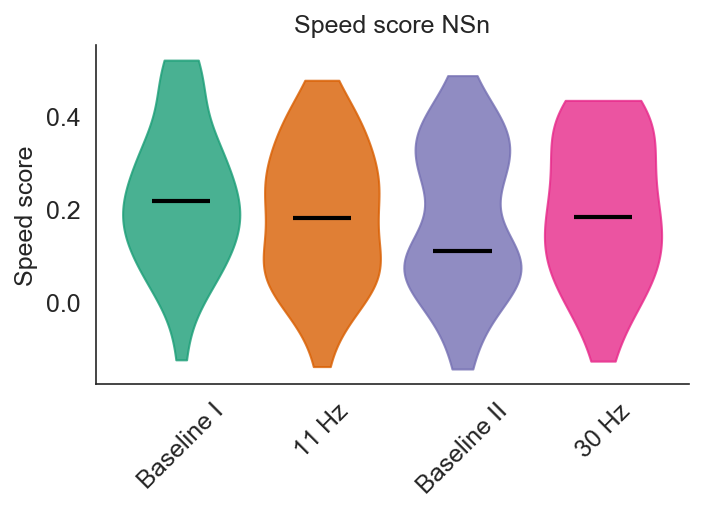

In [37]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['speed_score'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Speed score {cell_type}")
    plt.ylabel("Speed score")

    savefig(output_path / "figures" / f"speed_score_{cell_type}")

# Register in Expipe

In [55]:
action = project.require_action("comparisons-allcells")

In [56]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_speed_score.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/statistics_NSi.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_NSn_information_rate.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_information_specificity.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_NSi_selectivity.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_burst_event_ratio.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_NSi_speed_score.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_average_rate.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_sparsity.csv',
 '/media/st

In [40]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_allcells.ipynb")